In [541]:
#import datapane as dp
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from functools import reduce
import numpy as np
import random

In [542]:
%matplotlib inline
plt.style.use('ggplot')

# Need a list of features to aggregate a final score.
a1 = web censorshp block fraction
b1 = circumvention tool availability (torsf,tor,stunreachability,psiphon,riseupvpn)
c1 = Internet shutdown duration
d1 = radar IPv6 adoption rate
d2 = radar TLS1_3 adoption rate
e1 = CTI index
f1 = data localisation ranking

In [543]:
a1_path = "/Users/coes3/phd-labs/fraganal/data_source/ooni/wc/"

In [711]:
def a1_data_prep(path, fq='M'):
    files = Path(path).glob('*.csv')
    dfs = []

    for i in files:
        data = pd.read_csv(i, header=0)
        data['cc'] = i.name.split('_')[-1].strip('.csv')
        dfs.append(data)

    df = pd.concat(dfs, ignore_index=True)
    df.rename(columns={"measurement_start_day":"date", "confirmed_count":"blocked_count"}, inplace = True)
    
    
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
    
    #  filter for only 2022 data
    df = df.loc[(df['date'] >= '2022-01-01') & (df['date'] <='2022-12-31')]
    
    df['a1'] = (df['blocked_count']* 7) + (df['anomaly_count']*3)
    df.set_index('date', inplace=True)
    
    grouper = df.groupby([pd.Grouper(freq=fq), 'cc'])

    #calculate sum of points each frequency by country
    #result = grouper['points'].mean().unstack('cc').fillna(0)
    result = grouper['a1'].mean().fillna(0).reset_index()
    
    return result

In [712]:
a1_df = a1_data_prep(a1_path, fq='M')

In [713]:
a1_df

,date,cc,a1
0,2022-01-31,AD,1.730769
1,2022-01-31,AE,47.540441
2,2022-01-31,AF,12.207547
3,2022-01-31,AL,1.142857
4,2022-01-31,AM,39.758555
...,...,...,...
1914,2022-12-31,VN,25.418478
1915,2022-12-31,YE,118.485149
1916,2022-12-31,YT,0.545455
1917,2022-12-31,ZM,1.468750


In [714]:
b1_path = "/Users/coes3/phd-labs/fraganal/data_source/ooni/cir/"
cc_filepath = "/Users/coes3/phd-labs/fraganal/data_source/cc_alpha2_3.csv"

In [718]:
def b1_data_prep(path, fq='M'):
    files = Path(path).glob('*.csv')
    dfs = []

    for i in files:
        data = pd.read_csv(i, header=0)
        data['cc'] = i.name.split('_')[-1].strip('.csv')
        dfs.append(data)

    df = pd.concat(dfs, ignore_index=True)
    df.rename(columns={"measurement_start_day":"date", "confirmed_count":"blocked_count"}, inplace = True)
    
    
    #df = df[['date', 'blocked_count', 'anomaly_count', 'ok_count', 'cc']]
    
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
    
    #  filter for only 2022 data
    df = df.loc[(df['date'] >= '2022-01-01') & (df['date'] <='2022-12-31')]
    
    df['b1'] = (df['blocked_count']*7) + (df['anomaly_count']*3)
    df.set_index('date', inplace=True)
    
    grouper = df.groupby([pd.Grouper(freq=fq), 'cc'])

    #calculate sum of points each frequency by country
    #result = grouper['points'].mean().unstack('cc').fillna(0)
    result = grouper['b1'].mean().fillna(0).reset_index()
    

    return result


In [719]:
b1_df = b1_data_prep(b1_path, fq='M')

In [720]:
b1_df

,date,cc,b1
0,2022-01-31,AD,0.000000
1,2022-01-31,AE,1.372881
2,2022-01-31,AF,2.250000
3,2022-01-31,AL,0.000000
4,2022-01-31,AM,0.076923
...,...,...,...
1889,2022-12-31,VE,23.060000
1890,2022-12-31,VN,23.800000
1891,2022-12-31,YE,4.180328
1892,2022-12-31,ZM,2.735294


In [721]:
c1_path = "/Users/coes3/phd-labs/fraganal/data_source/shut/"

In [722]:
def c1_data_prep(path, fq='M'):
    files = Path(path).glob('*.csv')
    dfs = []

    for i in files:
        data = pd.read_csv(i, header=0)
        dfs.append(data)

    df = pd.concat(dfs, ignore_index=True)

    cc_df = pd.read_csv(cc_filepath)
    df = df.join(cc_df[['name', 'alpha-2']].set_index('name'), on='country')
    df.rename(columns = {'alpha-2':'cc'}, inplace = True)


    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])

    #  filter for only 2022 data 
    df = df.loc[(df['start_date'] >= '2022-01-01') & (df['start_date'] <='2022-12-31')]
    
    #  where end_date is null replace NaT with value of start_date for that row
    df['end_date'].where(df['end_date'].notnull(), df['start_date'], inplace=True)
    
    #  count a duration of shutdowns days between start and end date
    df['duration'] = (df['end_date'] - df['start_date']).dt.days
    
    #  count same day shutdown event as a half a day duration 0.5
    df['duration'].where(df['end_date'] != df['start_date'], 0.5, inplace=True)
    
    #df.drop(columns=['end_date'], inplace=True)
    df.rename(columns = {'start_date':'date'}, inplace = True)
    
    df['c1'] = df['duration']
    
    df = df[['date', 'cc', 'c1']]
    df.set_index('date', inplace=True)
    
    grouper = df.groupby([pd.Grouper(freq=fq), 'cc'])

    #calculate sum of points each frequency by country
    #result = grouper['points'].sum().unstack('cc').fillna(0)
    result = grouper['c1'].sum().fillna(0).reset_index()
    
    return result
    

In [723]:
c1_df = c1_data_prep(c1_path, fq='M')

In [724]:
c1_df

,date,cc,c1
0,2022-01-31,BF,15.0
1,2022-01-31,IN,24.5
2,2022-01-31,KZ,7.0
3,2022-01-31,MM,0.5
4,2022-01-31,SD,0.5
...,...,...,...
61,2022-12-31,BD,0.5
62,2022-12-31,IN,2.5
63,2022-12-31,IR,8.5
64,2022-12-31,JO,10.5


In [725]:
d1_path = "/Users/coes3/phd-labs/fraganal/data_source/radar/ip_version/"
d2_path = "/Users/coes3/phd-labs/fraganal/data_source/radar/tls_version/"

In [726]:
def d_data_prep(proto_type, path, fq='M'):
    #  function to prep radar data in pandas
    
    files = Path(path).glob(f'*.csv')
    dfs = []
    
    for i in files:
        data = pd.read_csv(i, index_col=None, header=0)
        data['cc'] = i.name.split('_')[-1].strip('.csv')
        dfs.append(data)
        
    df = pd.concat(dfs, ignore_index=True)

    df['date'] = pd.to_datetime(df['Serie_0 timestamps'], format='%Y-%m-%d')
    df['date'] = df['date'].dt.tz_convert(None)
   
    #  filter for only 2022 data
    df = df.loc[(df['date'] >= '2022-01-01') & (df['date'] <='2022-12-31')]
    
    if proto_type == "IP":
        df.rename(columns={"Serie_0  I Pv4":"ipv4", "Serie_0  I Pv6":"ipv6"}, inplace = True)
        
        df['d1'] = np.where((df['ipv4'] >= df['ipv6']), (df['ipv6']/df['ipv4'] * 100), (df['ipv4']/df['ipv6'] * 100))
        df = df[['date', 'cc', 'd1']]
        df.set_index('date', inplace=True)

        grouper = df.groupby([pd.Grouper(freq=fq), 'cc'])

        #calculate sum of points each frequency by country
        #result = grouper['points'].mean().unstack('cc').fillna(100)
        result = grouper['d1'].mean().fillna(100).reset_index()
        
        
    
    else:
        df.rename(columns={"Serie_0  T L S 1.3":"tlsv1_3", "Serie_0  T L S 1.2":"tlsv1_2", 
                           "Serie_0  T L S  Q U I C":"tlsvquic", "Serie_0  T L S 1.0":"tlsv1_0", "Serie_0  T L S 1.1":"tlsv1_1"}, inplace = True)
        #df = df[['date', 'cc', 'tlsv1_0', 'tlsv1_1', 'tlsv1_2']]
        df['t_old'] = (df['tlsv1_0'] + df['tlsv1_1'] + df['tlsv1_2'])
        df['t_new'] = (df['tlsv1_3'] + df['tlsvquic'])
        df['d2'] = np.where((df['t_old'] >= df['t_new']), (df['t_new']/df['t_old'] * 100), (df['t_old']/df['t_new'] * 100))
        df = df[['date', 'cc', 'd2']]
        df.set_index('date', inplace=True)

        grouper = df.groupby([pd.Grouper(freq=fq), 'cc'])

        #calculate sum of points each frequency by country
        #result = grouper['points'].mean().unstack('cc').fillna(100)
       
        result = grouper['d2'].mean().fillna(100).reset_index()
        
    
    return result

In [727]:
d1_df = d_data_prep('IP', d1_path, fq='M')

In [728]:
d2_df = d_data_prep('TLS', d2_path, fq='M')

In [729]:
d1_df

,date,cc,d1
0,2022-01-31,AD,0.575641
1,2022-01-31,AE,35.646741
2,2022-01-31,AF,0.059310
3,2022-01-31,AG,0.320141
4,2022-01-31,AI,0.104773
...,...,...,...
2971,2022-12-31,YE,0.034869
2972,2022-12-31,YT,28.811203
2973,2022-12-31,ZA,2.132571
2974,2022-12-31,ZM,0.097413


In [730]:
def agg_df(cc=True, fq='M'):
    
    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())
    
    a1_df = a1_data_prep(a1_path, fq=fq)
    b1_df = b1_data_prep(b1_path, fq=fq)
    c1_df = c1_data_prep(c1_path, fq=fq)
    d1_df = d_data_prep('IP', d1_path, fq=fq)
    d2_df = d_data_prep('TLS', d2_path, fq=fq)
    
    if cc:
        
        data_frames = [a1_df, b1_df, c1_df, d1_df, d2_df]
        agg_df = reduce(lambda  left,right: pd.merge(left, right, on=['date', 'cc'],
                                            how='left'), data_frames)
        agg_df[['a1', 'b1', 'c1']] = agg_df[['a1', 'b1', 'c1']].fillna(0)
        agg_df[['d1', 'd2']] = agg_df[['d1', 'd2']].fillna(100)
        

    else:
        a1_df2 = a1_df.groupby('date').agg({'a1': 'mean'}).reset_index()
        b1_df2 = b1_df.groupby('date').agg({'b1': 'mean'}).reset_index()
        c1_df2 = c1_df.groupby('date').agg({'c1': 'mean'}).reset_index()
        d1_df2 = d1_df.groupby('date').agg({'d1': 'mean'}).reset_index()
        d2_df2 = d2_df.groupby('date').agg({'d2': 'mean'}).reset_index()
        
        data_frames = [a1_df2, b1_df2, c1_df2, d1_df2, d2_df2]
        agg_df = reduce(lambda  left,right: pd.merge(left, right, on=['date'],
                                            how='left'), data_frames)
        agg_df[['a1', 'b1', 'c1']] = agg_df[['a1', 'b1', 'c1']].fillna(0)
        agg_df[['d1', 'd2']] = agg_df[['d1', 'd2']].fillna(100)
        
    col = agg_df.select_dtypes("number").columns
    weights ={ 'a1': 30, 'b1':10, 'c1': 40, 'd1': 10, 'd2': 10} 
    #why have you assigned these values to each feature?
    
    #apply weight multiplication calculation
    agg_df[col] = agg_df[col].mul(weights)
    
    #apply min-max calculation
    agg_df[col] = min_max_scaling(agg_df[col])
    agg_df["findex"] = agg_df.loc[:, col].mean(axis = 1).round(2)    
    return agg_df
    

In [731]:
mon_cc_agg_df = agg_df(cc=True, fq='M')

In [732]:
mon_agg_df = agg_df(cc=False, fq='M')

In [733]:
ann_cc_agg_df = agg_df(cc=True, fq='Y')

In [734]:
ann_agg_df = agg_df(cc=False, fq='Y')

In [735]:
ann_cc_agg_df

,date,cc,a1,b1,c1,d1,d2,findex
0,2022-12-31,AD,0.001670,0.000108,0.000000,0.008413,0.127897,0.03
1,2022-12-31,AE,0.028721,0.015270,0.000000,0.392312,0.216974,0.13
2,2022-12-31,AF,0.002151,0.002033,0.079792,0.001204,0.420045,0.10
3,2022-12-31,AG,0.000194,0.000000,0.000000,0.006593,0.133311,0.03
4,2022-12-31,AL,0.000930,0.001654,0.000000,0.003638,0.132183,0.03
...,...,...,...,...,...,...,...,...
193,2022-12-31,VN,0.006241,0.015438,0.000000,0.712053,0.039095,0.15
194,2022-12-31,YE,0.031101,0.006685,0.006938,0.000298,0.523430,0.11
195,2022-12-31,YT,0.000183,0.000000,0.000000,0.363997,0.067407,0.09
196,2022-12-31,ZM,0.002445,0.001413,0.000000,0.001148,0.130789,0.03


In [736]:
mon_cc_agg_df

,date,cc,a1,b1,c1,d1,d2,findex
0,2022-01-31,AD,0.000469,0.000000,0.0,0.006023,0.184066,0.04
1,2022-01-31,AE,0.012880,0.000574,0.0,0.373003,0.225716,0.12
2,2022-01-31,AF,0.003307,0.000941,0.0,0.000621,0.554546,0.11
3,2022-01-31,AL,0.000310,0.000000,0.0,0.001049,0.251388,0.05
4,2022-01-31,AM,0.010772,0.000032,0.0,0.030042,0.215579,0.05
...,...,...,...,...,...,...,...,...
1914,2022-12-31,VN,0.006887,0.009950,0.0,0.607435,0.057562,0.14
1915,2022-12-31,YE,0.032102,0.001748,0.0,0.000365,0.433434,0.09
1916,2022-12-31,YT,0.000148,0.000000,0.0,0.301477,0.052564,0.07
1917,2022-12-31,ZM,0.000398,0.001144,0.0,0.001019,0.131286,0.03


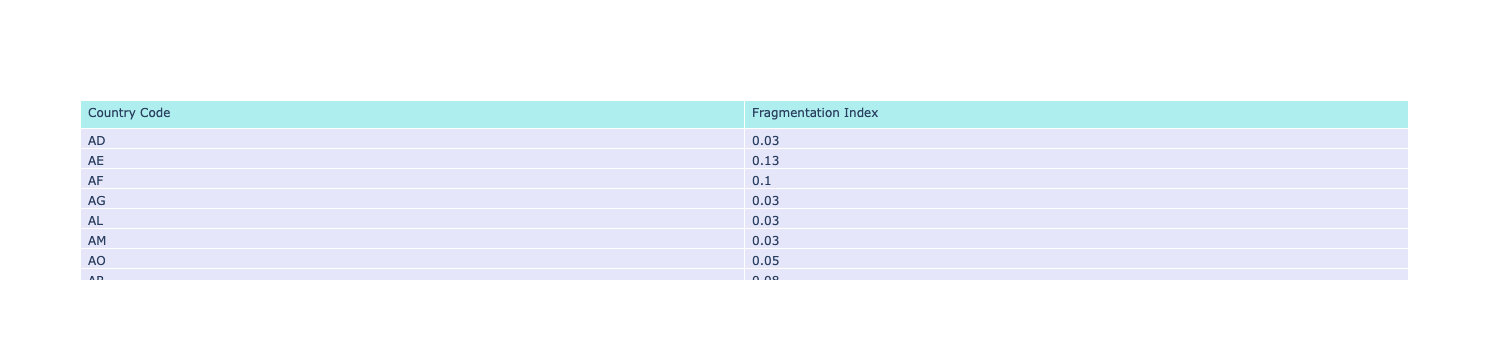

In [737]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Country Code', 'Fragmentation Index'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=ann_cc_agg_df[['cc', 'findex']].transpose().values.tolist(),
               fill_color='lavender',
               align='left'))
])

fig.show()

In [738]:
def plot_timeseries(df):
    fig = px.scatter(df, x="date", y="findex", hover_data=['findex'], template='simple_white')
    fig.update_xaxes(dtick="M1", tickformat="%b\n%Y")
    fig.show()

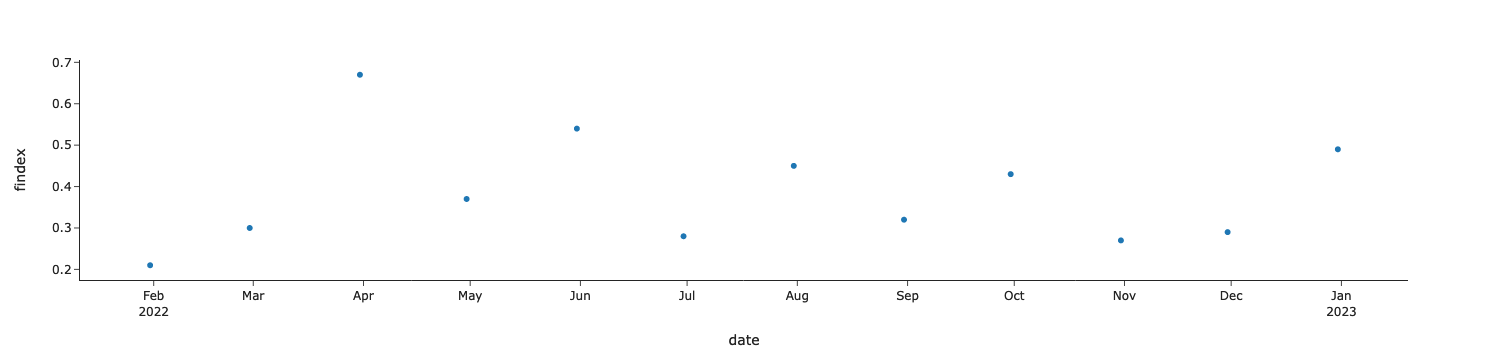

In [739]:
plot_timeseries(mon_agg_df)

In [740]:
def plot_cc_timeseries(df, cc):
    
    cc_df = df[df['cc'].isin(cc)]
    fig = px.line(cc_df, x="date", y="findex", color='cc')
    fig.show()


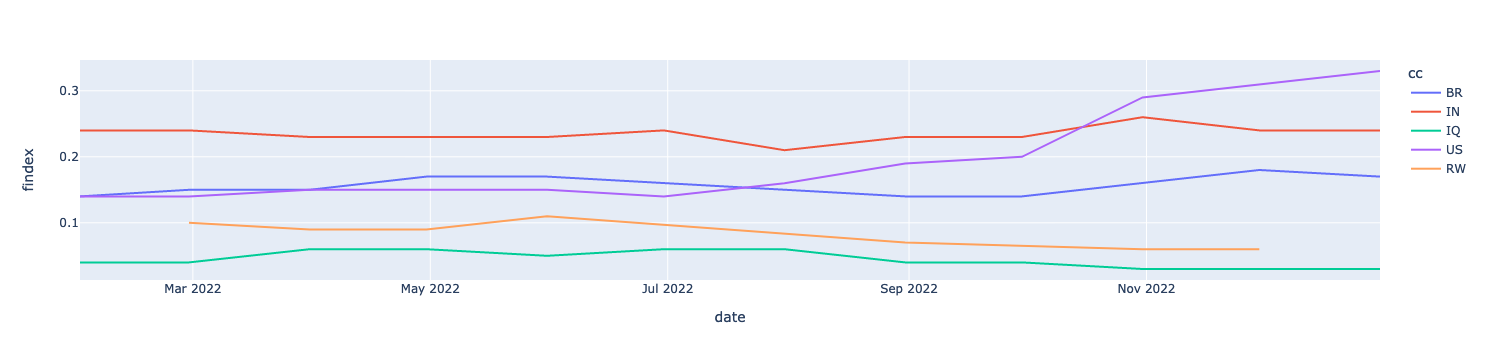

In [741]:
cc = ['US', 'BR', 'IN', 'IQ', 'RW']
plot_cc_timeseries(mon_cc_agg_df, cc)

In [742]:
def create_map_plot(df):
    cc_df = pd.read_csv(cc_filepath)
    df = df.join(cc_df[['alpha-2', 'alpha-3', 'name']].set_index('alpha-2'), on='cc')
   
    fig = px.choropleth(df, locations="alpha-3",
                    color="findex", # lifeExp is a column of gapminder
                    hover_name="name", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                    height = 500,
                    width = 1000)
    fig.show()
    

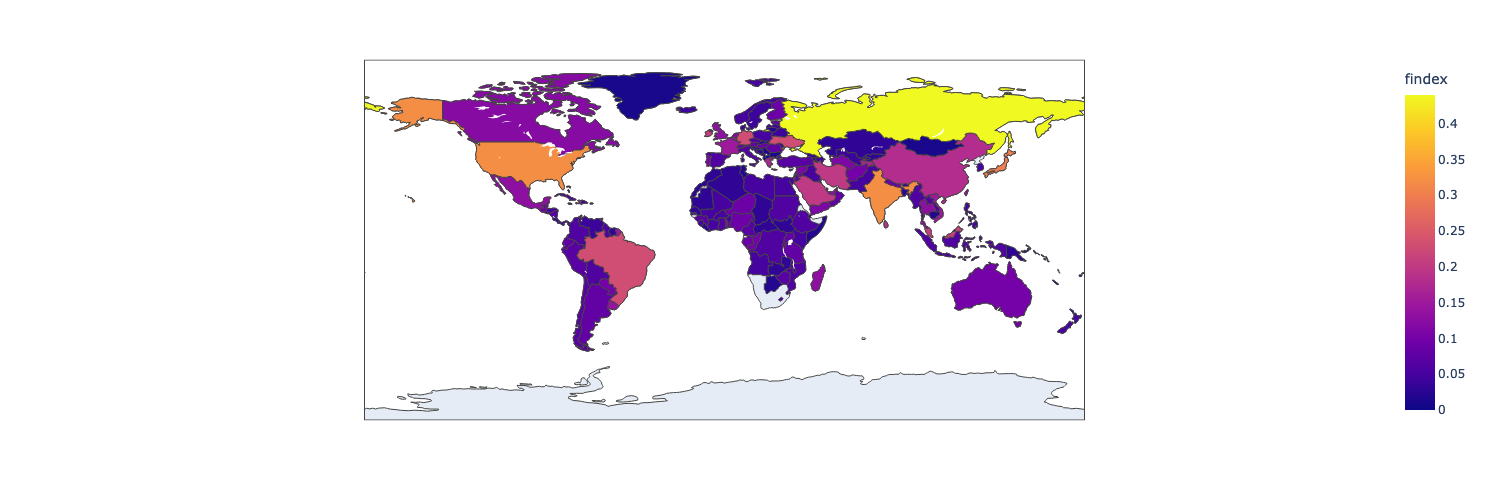

In [743]:
create_map_plot(ann_cc_agg_df)

In [763]:
def create_radar_plot(df, cc):
    subjects=['web_censorship','circumvention_tools','internet_shutdowns','ip_versions', 'tls_versions']
    cc_df = df[df['cc'] == cc].drop(columns=['date','cc', 'findex'])
    val = cc_df.values.tolist()[0]
    angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    subjects.append(subjects[0])
    val.append(val[0])
    
    fig=plt.figure(figsize=(6,6))
    ax=fig.add_subplot(111, polar=True)
    ax.plot(angles,val, 'o-', color='g', linewidth=1, label=cc)
    ax.fill(angles, val, alpha=0.25, color='g')
    ax.set_thetagrids(angles * 180/np.pi, subjects)

    plt.tight_layout()
    plt.legend()
    plt.show()

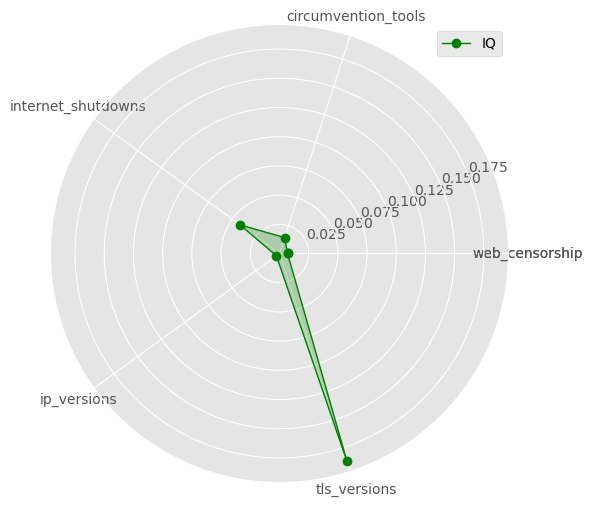

In [764]:
create_radar_plot(ann_cc_agg_df, 'IQ')

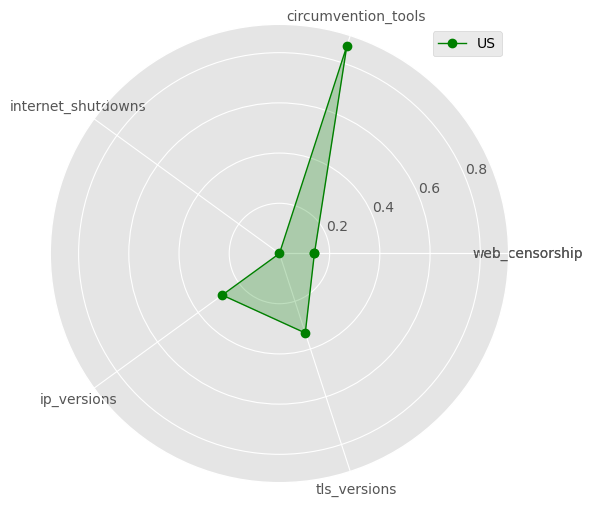

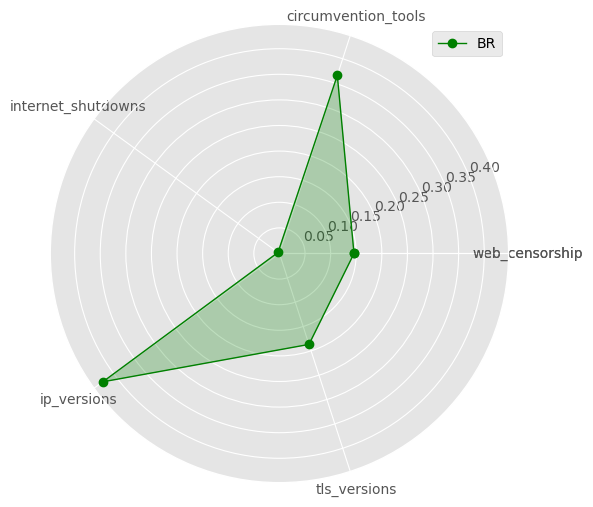

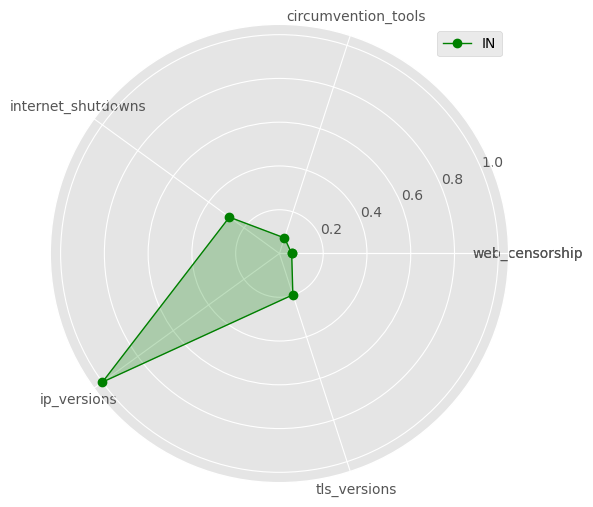

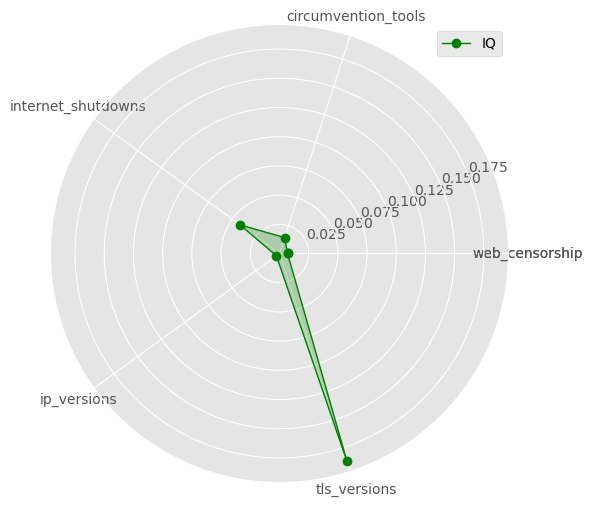

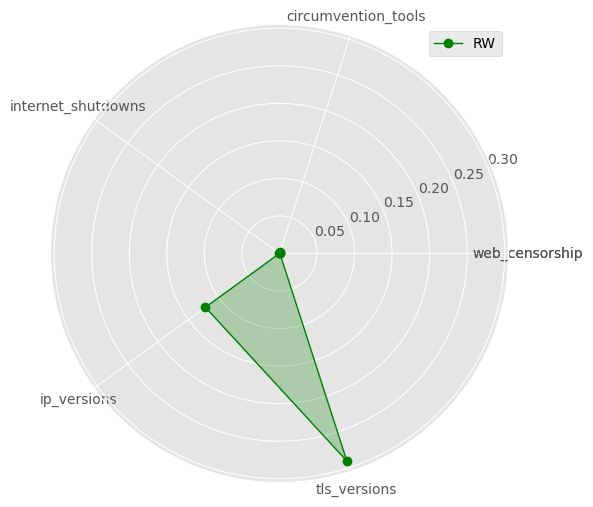

In [765]:
cc = ['US', 'BR', 'IN', 'IQ', 'RW']
for i in cc:
    create_radar_plot(ann_cc_agg_df, i)

In [766]:
def create_radar_multiplot(df, cc):
    colors = "bgrcmykw"
    color_index = 0
    
    d = {}
    subjects=['web_censorship','circumvention_tools','internet_shutdowns','ip_versions', 'tls_versions']
    
    angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    subjects.append(subjects[0])
    
    
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111, polar=True)
    ax.set_thetagrids(angles * 180/np.pi, subjects)
    for i in cc:
            random_color= ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
            
            cc_df = df[df['cc'] == i].drop(columns=['date','cc', 'findex'])
            d[f"val_{i}"] = cc_df.values.tolist()[0]
            d[f"val_{i}"].append(d[f"val_{i}"][0])
        
            ax.plot(angles,d[f"val_{i}"], 'o-', color=colors[color_index], linewidth=1, label=i)
            ax.fill(angles, d[f"val_{i}"], alpha=0.25, color=colors[color_index])
            color_index += 1

    plt.tight_layout()
    plt.legend()
    plt.show()

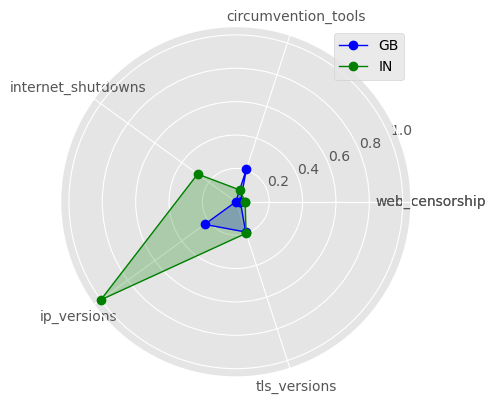

In [768]:
cc = ['GB', 'IN']
create_radar_multiplot(ann_cc_agg_df, cc)

Plot a 1D spectrum graph

In [ ]:
def create_frag_spec(df):
    a = [1,2,5,6,9,11,15,17,18]

plt.hlines(1,1,20)  # Draw a horizontal line
plt.xlim(0,21)
plt.ylim(0.5,1.5)

y = np.ones(np.shape(a))   # Make all y values the same
plt.plot(a,y,'|',ms = 40)  # Plot a line at each location specified in a
plt.axis('off')
plt.show()

In [750]:
ann_agg_df

,date,a1,b1,c1,d1,d2,findex
0,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN
